# Постановка задачи кластеризации

Пусть $X$ — множество объектов, $Y$ — множество номеров (имён, меток) кластеров.
- Задана функция расстояния между объектами $ \rho(x,x')$.
- Имеется конечная обучающая выборка объектов $X^m = \{ x_1, \dots, x_m \} \subset X$.
- Требуется разбить выборку на непересекающиеся подмножества, называемые кластерами, так, чтобы каждый кластер состоял из объектов, близких по метрике $\rho$, а объекты разных кластеров существенно отличались. При этом каждому объекту $x_i\in X^m$ приписывается номер кластера $y_i$.

Алгоритм кластеризации — это функция $a:\, X\to Y$, которая любому объекту $x\in X$ ставит в соответствие номер кластера $y\in Y$. Множество $Y$ в некоторых случаях известно заранее, однако чаще ставится задача определить оптимальное число кластеров, с точки зрения того или иного критерия качества кластеризации.


Кластеризация (обучение без учителя) отличается от классификации (обучения с учителем) тем, что метки исходных объектов $y_i$ изначально не заданы, и даже может быть неизвестно само множество $Y$.

Выше постановка чёткой кластеризации (одному объекту сопоставляется один кластер). Выделяют ещё нечеткую кластеризацию, когда одному объекту сопоставляется несколько кластеров, с некоторыми весами. С ней вы встретитесь при работе над тематическим моделированием.

## Ничего идеального нет

Введем несколько определений.

*Определение 1:*
> Алгоритм кластеризации $a$ является **масштабно-инвариантным** (англ. scale-invariant), если для любой функции расстояния $\rho$ и любой константы $\alpha>0$ результаты кластеризации с использованием расстояний $ρ$ и $α⋅ρ$ совпадают.

*Определение 2:*
> **Полнота** (англ. Richness). Множество результатов кластеризации алгоритма $a$ в зависимости от изменения функции расстояния $ρ$ должно совпадать со множеством всех возможных разбиений множества объектов $X$.

*Определение 3:*
> Функция расстояния $ρ′$ является **допустимым преобразованием** функции расстояния $ρ$, если
  1. $\rho′(x_i,x_j)\leq\rho(x_i,x_j)$, если $x_i$ и $x_j$ лежат в одном кластере; (сужает)
  2. $\rho′(x_i,x_j)\geq \rho(x_i,x_j)$, если $x_i$ и $x_j$ лежат в разных кластерах. (растягивает)

*Определение 4:*
> Алгоритм кластеризации является **согласованным** (англ. consistent), если результат кластеризации не изменяется после допустимого преобразования функции расстояния.

---
**Теорема Клейнберга о невозможности:**
> Для множества объектов, состоящего из двух и более элементов, не существует алгоритма кластеризации, который был бы одновременно *масштабно-инвариантным*, *согласованным* и *полным*.



Доказательство: https://www.cs.cornell.edu/home/kleinber/nips15.pdf

Решение задачи кластеризации принципиально неоднозначно, и тому есть несколько причин:

- Не существует однозначно **наилучшего критерия качества** кластеризации. Известен целый ряд эвристических критериев, а также ряд алгоритмов, не имеющих чётко выраженного критерия, но осуществляющих достаточно разумную кластеризацию «по построению». Все они могут давать разные результаты.
- **Число кластеров**, как правило, неизвестно заранее и устанавливается в соответствии с некоторым субъективным критерием.
- Результат кластеризации существенно зависит от **метрики**, выбор которой, как правило, также субъективен и определяется экспертом.

# Генерация датасета

Два варианта:
- sklearn.datasets.make_blobs -- сгенерировать просто точки (сужает количество вариантов используемых метрик качества, но близко к реальной постановке).<details>
<summary>на самом деле нет</summary>
make_blobs тоже генерирует информацию о принадлежности к кластеру, поищите (thx to GUN1A)
</details>
- sklearn.datasets.make_classification -- сгенерировать точки и метки для них (метки при обучении не используются, только при оценке качества).



In [2]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt


data, data_y = make_classification(n_samples=300, n_classes=2, n_features=2, n_redundant=0, n_clusters_per_class=2, flip_y=0, random_state=110)

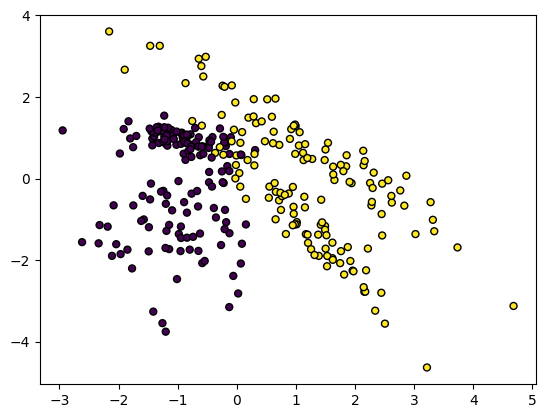

In [3]:
# как видит классификатор
plt.scatter(data[:, 0], data[:, 1], marker="o", c=data_y, s=25, edgecolor="k")
plt.show()

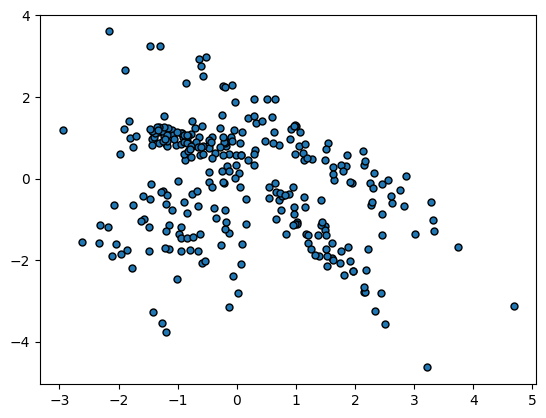

In [4]:
# как видит кластеризатор
plt.scatter(data[:, 0], data[:, 1], marker="o", s=25, edgecolor="k")
plt.show()

# Алгоритмы кластеризации

## K-means

[Описание метода](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_k-%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D0%B8%D1%85)

![](https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif)

Шаги алгоритма:
```
1. Выбрать случайно координаты центроидов для каждого кластера.
2. Посчитать расстояния от каждого объекта до центроидов.
3. Посчитать центр масс (центроид) каждого кластера.
4. Проверить условие остановки, вернуться к шагу 2.
```

От начального выбора центроидов зависит качество и скорость сходимости. Существуют модификации, которые улучшают случайный выбор ([K-means++](https://ru.wikipedia.org/wiki/K-means%2B%2B), например)

In [5]:
from sklearn.cluster import KMeans

kmeans = KMeans(2, n_init='auto').fit(data)

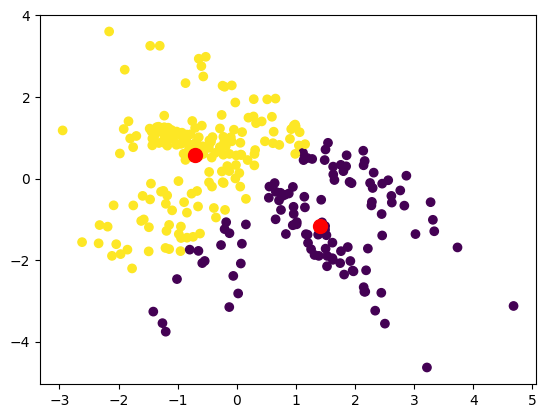

In [6]:
plt.scatter(data[:,0], data[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, c='red')

# Оценка качества кластеризации

Меры оценки кластеризации бывают двух видов:
- Внутренние -- меры отображают качество кластеризации только по информации в данных
- Внешние -- меры основаны на сравнении результата кластеризации с априори известным разделением на классы

[Большой список мер оценки](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8)

[Поменьше, но с картинками](https://habr.com/ru/companies/yandex/articles/500742/)

Самые частые:
- Внутренние: силуэт
- Внешние: rand score

In [7]:
from sklearn.metrics.cluster import rand_score

rand_score(kmeans.labels_, data_y)

0.6305239687848383

In [8]:
from sklearn.metrics import silhouette_score

silhouette_score(data, kmeans.labels_)

0.43210036054559814

# Подбор оптимального количества кластеров

Количество кластеров -- обычный гиперпараметр.
Т.о. для подбора оптимального гиперпараметра нужно определиться с оценкой качества алгоритма и списком значений для гиперпараметра.

## Метод локтя
Существует метод локтя, который использует такую оценку как [ компактность](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8#.D0.9A.D0.BE.D0.BC.D0.BF.D0.B0.D0.BA.D1.82.D0.BD.D0.BE.D1.81.D1.82.D1.8C_.D0.BA.D0.BB.D0.B0.D1.81.D1.82.D0.B5.D1.80.D0.BE.D0.B2_.28.D0.B0.D0.BD.D0.B3.D0.BB._Cluster_Cohesion.29) (kmeans.inertia_).



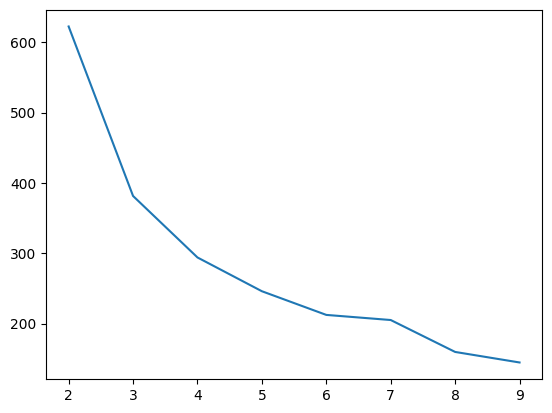

In [9]:
inertias = []

for i in range(2, 10):
  m = KMeans(i, n_init='auto').fit(data)
  inertias.append(m.inertia_)

plt.plot(range(2,10), inertias)

## Метод силуэта

Использует понятно какую [метрику](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8#.D0.A1.D0.B8.D0.BB.D1.83.D1.8D.D1.82_.28.D0.B0.D0.BD.D0.B3.D0.BB._Silhouette.29)

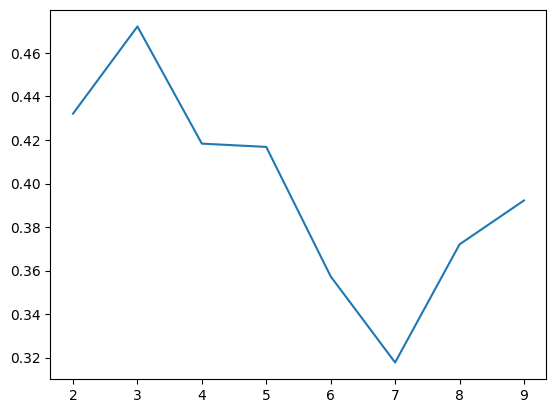

In [10]:
from sklearn.metrics import silhouette_score

ss = []

for i in range(2, 10):
  ss.append(silhouette_score(data, KMeans(i, n_init='auto').fit(data).labels_))

plt.plot(range(2,10), ss)

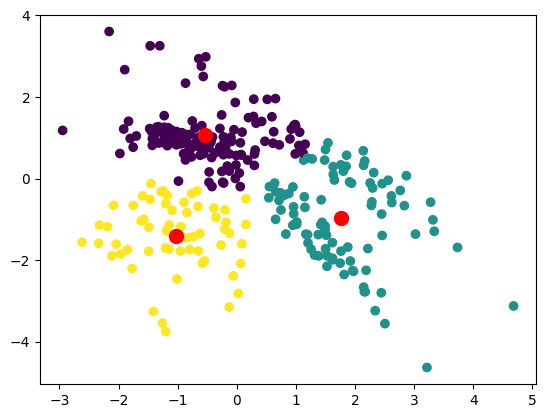

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(3, n_init='auto').fit(data)

plt.scatter(data[:,0], data[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, c='red')

# Алгоритмы кластеризации

## Affinity propagation

[Хорошее объяснение](https://habr.com/ru/articles/321216/)

Affinity Propagation (AP) - это алгоритм кластеризации, основанный на передаче сообщений между точками данных. В отличие от других алгоритмов кластеризации, таких как K-means, AP не требует заранее определенного числа кластеров. Для этой цели двумя важными параметрами являются "preference", которые контролируют количество экземпляров и "damping factor", который снижает ответственность и доступность сообщений, чтобы избежать числовых колебаний при обновлении этих сообщений. Подбираются через поиск по сетке.

---

Шаги работы алгоритма Affinity Propagation:
1. Инициализация: Создайте матрицу сходства S, где каждый элемент s(i, j) представляет сходство между точками данных i и j. Обычно сходство определяется как отрицательное квадратное евклидово расстояние. Затем инициализируйте две другие матрицы: матрицу ответственности R и матрицу доступности A, заполнив их нулями.

2. Обновление ответственности: Обновите матрицу ответственности R, используя текущие значения матрицы доступности A и матрицы сходства S. Ответственность r(i, k) отражает насколько подходящим является объект k в качестве экземпляра для объекта i.

3. Обновление доступности: Обновите матрицу доступности A, используя текущие значения матрицы ответственности R. Доступность a(i, k) отражает насколько подходящим является объект i для выбора объекта k в качестве экземпляра.

4. Сходимость: Повторяйте шаги 2 и 3 до тех пор, пока не будет достигнут критерий сходимости. Обычно это означает, что значения матриц R и A стабилизируются после определенного числа итераций.


Выделение кластеров: После сходимости определите кластеры, выбрав для каждого объекта i экземпляр k, который максимизирует сумму ответственности r(i, k) и доступности a(i, k).
В результате работы алгоритма Affinity Propagation получаем кластеры с автоматически определенным числом кластеров и экземплярами, представляющими каждый кластер.


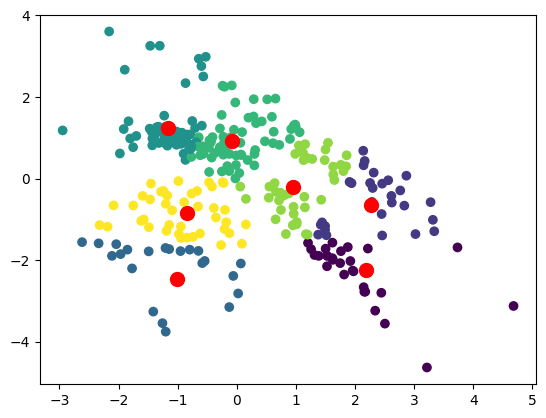

In [12]:
from sklearn.cluster import AffinityPropagation

clustering = AffinityPropagation(preference=-42).fit(data)

plt.scatter(data[:,0], data[:,1], c=clustering.labels_)
plt.scatter(clustering.cluster_centers_[:,0], clustering.cluster_centers_[:,1], s=100, c='red')

## DB-SCAN


- Находим точки в $\epsilon$  окрестности каждой точки и выделяем основные точки с более чем minPts соседями.

- Находим связные компоненты основных точек на графе соседей, игнорируя все неосновные точки.

- Назначаем каждую неосновную ближайшему кластеру, если кластер является $\epsilon$ -соседним, в противном случае считаем точку шумом.

[-1  0]


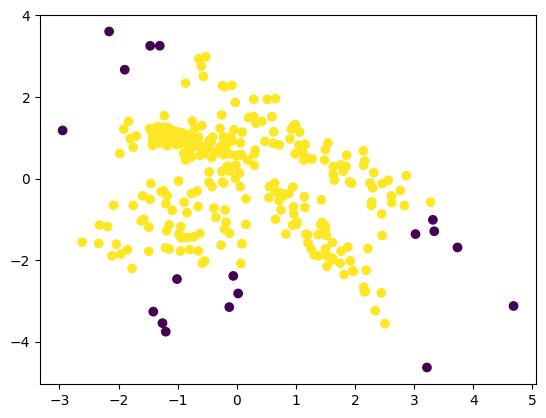

In [13]:
from sklearn.cluster import DBSCAN
import numpy as np

dbscan = DBSCAN().fit(data)

print(np.unique(dbscan.labels_))
plt.scatter(data[:,0], data[:,1], c=dbscan.labels_)

[-1  0  1  2  3  4  5]


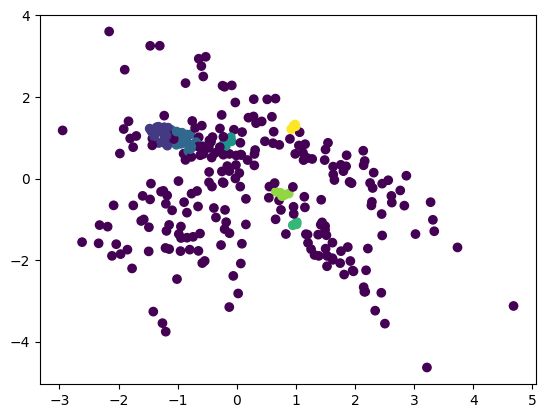

In [14]:
dbscan = DBSCAN(eps=0.1, min_samples=4).fit(data)
print(np.unique(dbscan.labels_))
plt.scatter(data[:,0], data[:,1], c=dbscan.labels_)

In [15]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=4).fit(data)
distances, indices = nbrs.kneighbors(data)
distances

array([[0.        , 0.14075262, 0.36792915, 0.44996652],
       [0.        , 0.03239929, 0.03600522, 0.07527797],
       [0.        , 0.11009673, 0.19382091, 0.21479119],
       ...,
       [0.        , 0.28260111, 0.32034932, 0.33287071],
       [0.        , 0.03065035, 0.05157891, 0.06290576],
       [0.        , 0.05460523, 0.06462845, 0.07566198]])

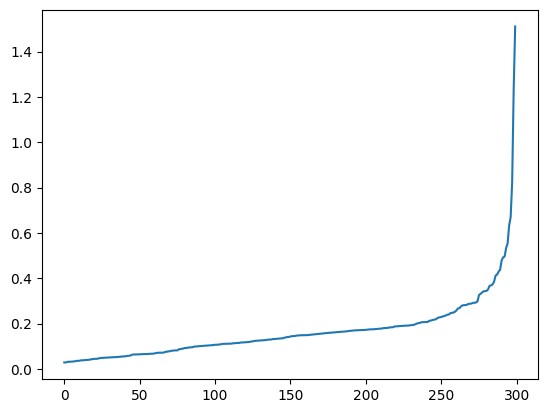

In [16]:
distances = np.mean(distances, axis=1)
distances = np.sort(distances)
# distances
plt.plot(distances)

[-1  0  1  2  3  4  5]


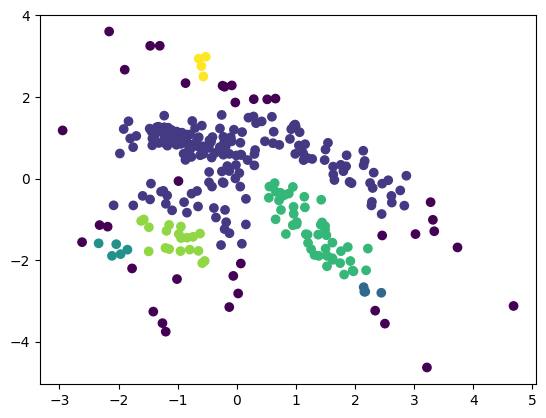

In [17]:
dbscan = DBSCAN(eps=0.35, min_samples=4).fit(data)
print(np.unique(dbscan.labels_))
plt.scatter(data[:,0], data[:,1], c=dbscan.labels_)

# Gaussian Mixtures, EM

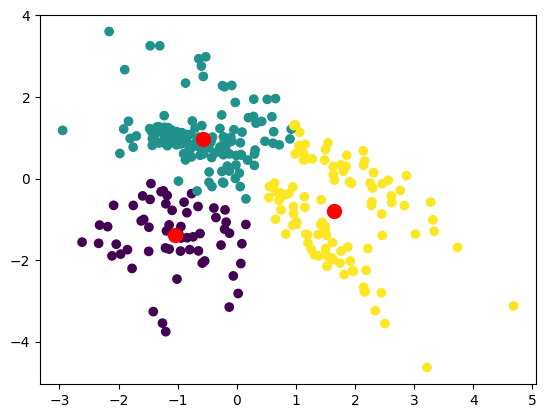

In [45]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3).fit(data)

gm.predict(data)

plt.scatter(data[:,0], data[:,1], c=gm.predict(data))
plt.scatter(gm.means_[:,0], gm.means_[:,1], s=100, c='red')

## Иерархическая кластеризация

https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering


In [19]:
from scipy.cluster import hierarchy

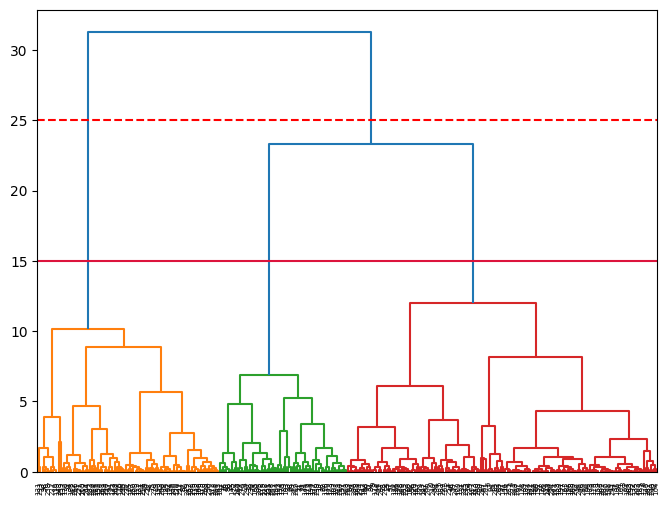

In [20]:
clusters = hierarchy.linkage(data, method="ward")

plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)
# Plotting a horizontal line based on the first biggest distance between clusters
plt.axhline(25, color='red', linestyle='--');
# Plotting a horizontal line based on the second biggest distance between clusters
plt.axhline(15, color='crimson');

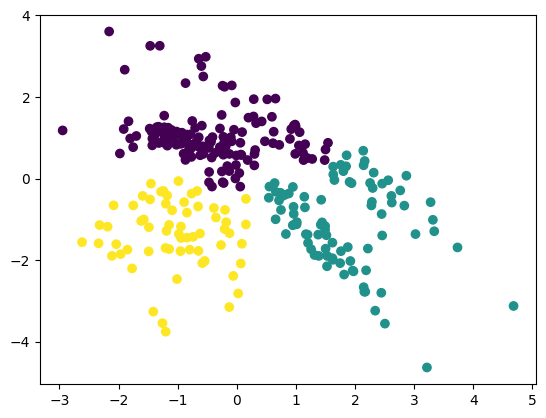

In [21]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=3, linkage="ward").fit(data)
plt.scatter(data[:,0], data[:,1], c=clustering.labels_)

## Карты Кохонена


Крутой разбор: https://habr.com/ru/articles/338868/



In [22]:
# simpSOM
# https://pypi.org/project/sklearn-som/
!pip install sklearn_som


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
from sklearn_som.som import SOM

In [24]:
iris_som = SOM(m=2, n=1, dim=2)
iris_som.fit(data)

In [25]:
predictions = iris_som.predict(data)

In [26]:
predictions

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1], d

# Задание

1. Сгенерировать 3 датасета (make_classification или make_blobs)
2. Провести визуализацию
3. Провести кластеризацию (все методы)
4. Для каждого метода подобрать оптимальные гипер-параметры.
5. Самостоятельно реализовать KMeans. Проверить его работу на датасетах.
6. Каждый метод оценивать 2 внешними и 2 внутренними метриками.

# Доп. задание:

Реализовать DB-Scan

$%внизу лишний пробел$
! [](https://wojakparadise.net/wojak/3038/img)

## 1. Генерация 3 датасетов + визуализация

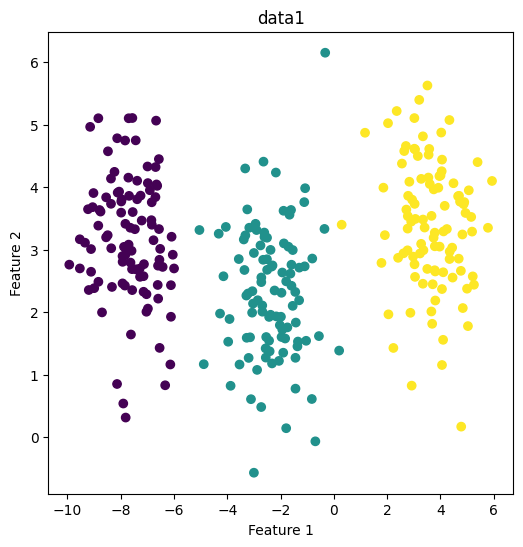

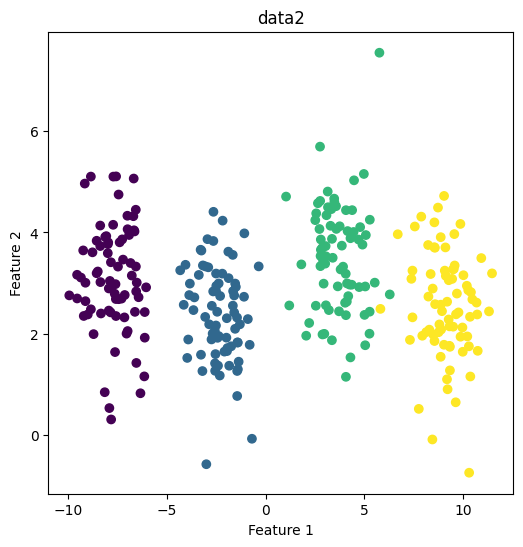

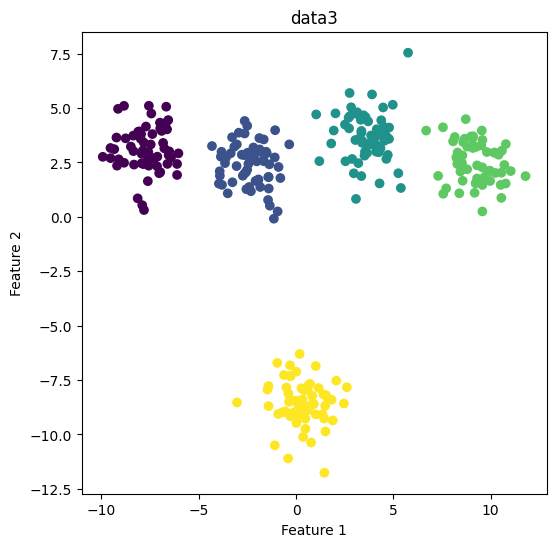

In [27]:
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt


data1, data_y1 = make_blobs(n_samples=300, centers=3, n_features=2, random_state=110)
data2, data_y2 = make_blobs(n_samples=300, centers=4, n_features=2, random_state=110)
data3, data_y3 = make_blobs(n_samples=300, centers=5, n_features=2, random_state=110)

plt.figure(figsize=(6,6))
plt.scatter(data1[:,0], data1[:,1], c=data_y1)
plt.title('data1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
plt.close()

plt.figure(figsize=(6,6))
plt.scatter(data2[:,0], data2[:,1], c=data_y2)
plt.title('data2')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
plt.close()

plt.figure(figsize=(6,6))
plt.scatter(data3[:,0], data3[:,1], c=data_y3)
plt.title('data3')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
plt.close()

## 2. Кластеризация (все методы)

### KMeans

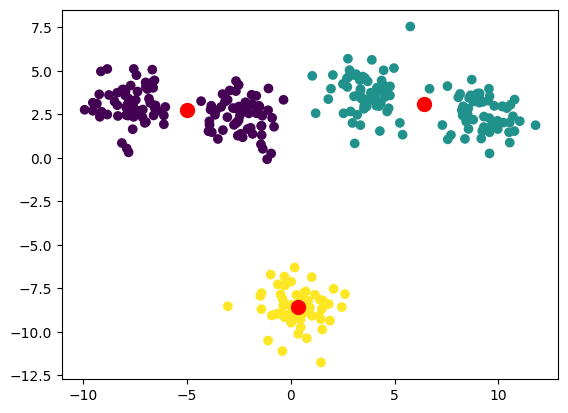

In [49]:
from sklearn.cluster import KMeans

kmeans = KMeans(3, n_init='auto').fit(data3)
plt.scatter(data3[:,0], data3[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, c='red')

#### Поиск оптимального гиперпараметра

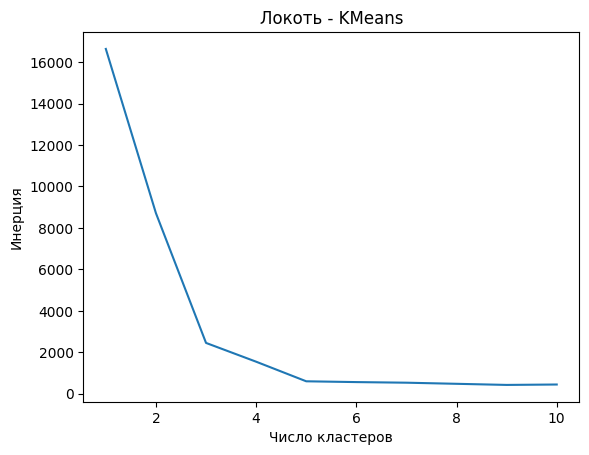

In [60]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(k, n_init='auto').fit(data3)
    inertias.append(kmeans.inertia_)


plt.plot(k_values, inertias)
plt.xlabel('Число кластеров')
plt.ylabel('Инерция')
plt.title('Локоть - KMeans')
plt.show()


#### Внутренняя оценка

In [29]:
from sklearn.metrics import silhouette_score
silhouette_score(data3, kmeans.labels_)


0.6891141170230013

#### Внешняя оценка

In [30]:
from sklearn.metrics.cluster import rand_score
rand_score(kmeans.labels_, data_y3)

0.8394648829431438

### Afinity propagation

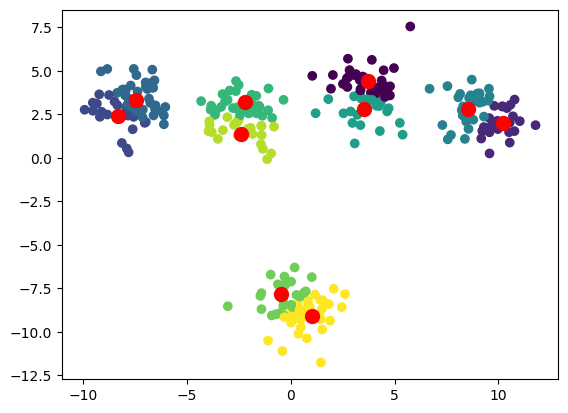

In [31]:
from sklearn.cluster import AffinityPropagation

clustering = AffinityPropagation(preference=-42).fit(data3)

plt.scatter(data3[:,0], data3[:,1], c=clustering.labels_)
plt.scatter(clustering.cluster_centers_[:,0], clustering.cluster_centers_[:,1], s=100, c='red')

#### Внутренняя

In [32]:
from sklearn.metrics import silhouette_score
silhouette_score(data3, clustering.labels_)

0.32291255595374513

#### Внешняя

In [33]:
from sklearn.metrics.cluster import rand_score
rand_score(data_y3, clustering.labels_)

0.9025863991081382

### DBSCAN

[-1  0  1  2  3  4]


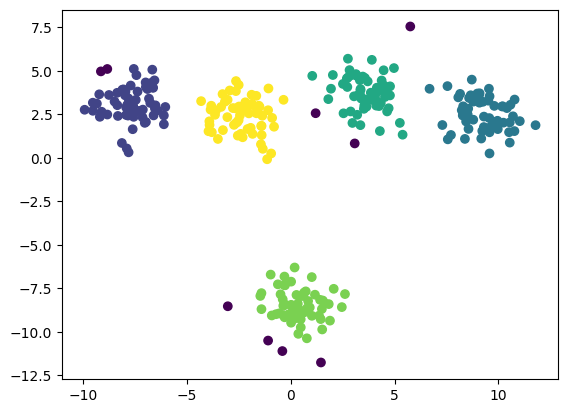

In [87]:
from sklearn.cluster import DBSCAN
import numpy as np

dbscan = DBSCAN(eps=1, min_samples=4).fit(data3)

print(np.unique(dbscan.labels_))
plt.scatter(data3[:,0], data3[:,1], c=dbscan.labels_)

#### Внешняя

In [88]:
from sklearn.metrics.cluster import rand_score
rand_score(data_y3, dbscan.labels_)

0.9880267558528428

#### Внутренняя

In [89]:
from sklearn.metrics import silhouette_score
silhouette_score(data3, dbscan.labels_)

0.66291002054648

### GaussianMixture

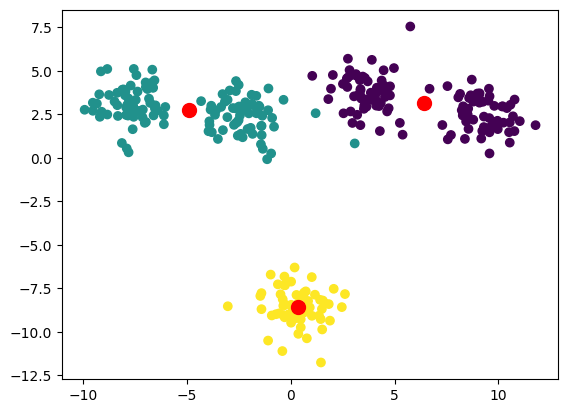

In [46]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3).fit(data3)

gm.predict(data3)

plt.scatter(data3[:,0], data3[:,1], c=gm.predict(data3))
plt.scatter(gm.means_[:,0], gm.means_[:,1], s=100, c='red')

#### Поиск оптимального гиперпараметра

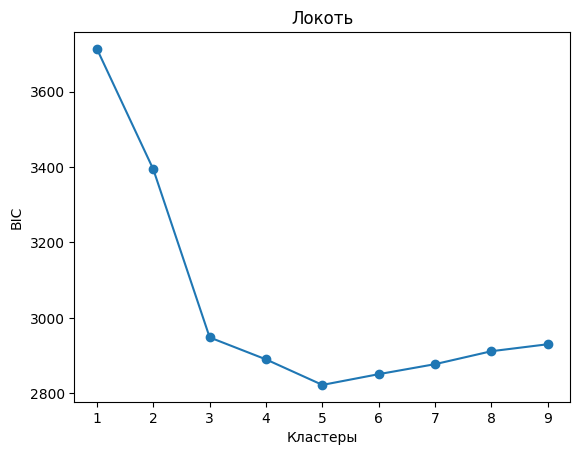

In [59]:
n_components = range(1, 10)
inertias = []

for n in range(1, 10):
    gm = GaussianMixture(n_components=n)
    gm.fit(data3)
    inertias.append(gm.bic(data3))

# Построение графика локтя
plt.plot(n_components, inertias, marker='o')
plt.xlabel('Кластеры')
plt.ylabel('BIC')
plt.title('Локоть')
plt.show()

### Иерархическая кластеризация

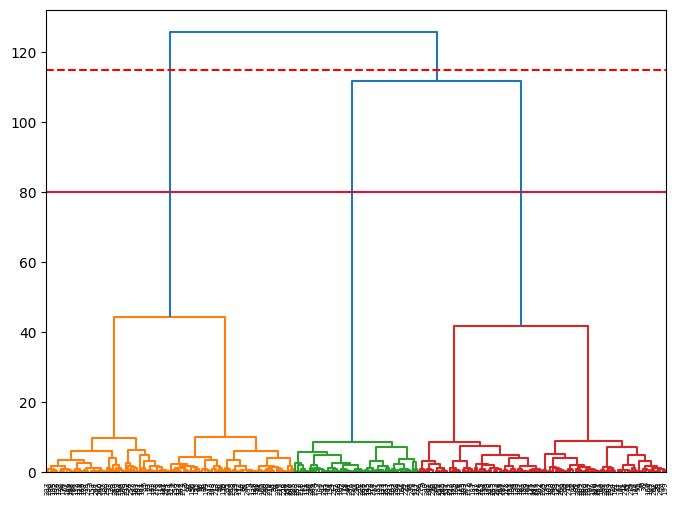

In [38]:
from scipy.cluster import hierarchy
clusters = hierarchy.linkage(data3, method="ward")

plt.figure(figsize=(8, 6))
dendrogram = hierarchy.dendrogram(clusters)
plt.axhline(115, color='red', linestyle='--');
plt.axhline(80, color='crimson');

# Сделать K-means

In [169]:
import numpy as np

def kmeans(X, n_clusters, max_iters=100):
    centroids = X[np.random.choice(range(len(X)), n_clusters, replace=False)]
    
    for _ in range(max_iters):
        distances = []

        for i in range(len(centroids)):
            distances.append(np.sqrt(np.sum((X - centroids[i])**2, axis=1)))
        
        labels = np.argmin(distances, axis=0)
        
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(n_clusters)])
        
        centroids = new_centroids
    
    return labels, centroids


labels, centroids = kmeans(data3, 3)
print(labels)
print(centroids)


[1 2 2 2 1 2 2 0 1 1 1 1 0 2 0 2 2 1 2 2 1 2 1 0 1 2 1 0 2 2 2 2 2 1 2 2 1
 0 1 1 2 0 1 0 1 0 0 1 2 1 2 1 0 2 1 2 2 0 2 1 2 2 1 1 1 1 1 2 2 2 2 1 0 2
 0 1 2 2 1 1 2 2 2 0 2 2 1 1 2 2 2 0 0 2 1 1 1 1 2 0 2 1 2 1 0 1 0 1 1 0 2
 0 2 2 2 1 0 0 0 2 1 2 1 2 2 2 1 2 1 1 2 1 2 2 1 1 2 1 1 2 1 1 1 0 2 0 2 1
 2 1 1 2 2 2 0 0 2 2 1 1 1 2 1 0 1 1 2 1 2 1 0 0 2 1 2 1 2 2 0 2 2 2 1 2 1
 1 1 1 1 1 2 0 0 1 1 2 0 0 2 1 1 1 2 2 1 1 2 1 0 1 2 1 1 2 0 1 1 0 0 1 0 0
 0 2 2 2 0 1 2 1 1 0 2 2 0 1 0 2 1 2 2 0 1 2 2 1 2 2 1 1 2 0 0 0 1 2 2 2 0
 1 2 2 1 2 1 1 1 1 0 0 2 1 0 2 1 1 1 0 2 1 2 1 1 1 2 1 1 1 2 1 1 0 2 2 1 2
 0 0 2 2]
[[ 0.32997171 -8.54931697]
 [-5.02255749  2.75953492]
 [ 6.40929534  3.10774719]]


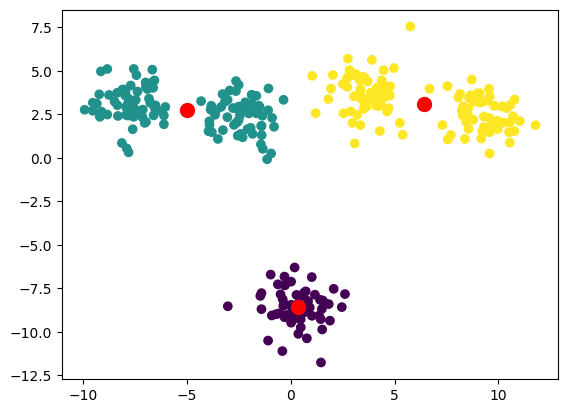

In [170]:
plt.scatter(data3[:,0], data3[:,1], c=labels)
plt.scatter(centroids[:,0], centroids[:,1], s = 100, c = 'red')

In [171]:
from sklearn.metrics.cluster import rand_score
rand_score(data_y3, labels)

0.8394648829431438

In [172]:
from sklearn.metrics import silhouette_score
silhouette_score(data3, labels)

0.6891141170230013

### Для тестов

In [134]:
X = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]])
centroids = X[np.random.choice(range(len(X)), 3, replace=False)]
centroids

array([[ 1,  0],
       [10,  0],
       [10,  4]])

In [102]:
X

array([[ 1,  2],
       [ 1,  4],
       [ 1,  0],
       [10,  2],
       [10,  4],
       [10,  0]])

In [132]:
X - centroids[0]

array([[-9,  2],
       [-9,  4],
       [-9,  0],
       [ 0,  2],
       [ 0,  4],
       [ 0,  0]])

In [135]:
np.sum([[1,2],[3,4]], axis=1)

array([3, 7])

In [138]:
np.argmin([[1, 5, 3],[4,2,6]],axis=0)

array([0, 1, 0], dtype=int64)

In [154]:
data = np.array([[1, 2], [1, 4], [1, 0], [10, 2], [10, 4], [10, 0]]).mean(axis=0)
data

array([5.5, 2. ])